In [1]:
##You may not import anything for this assignment, all accuracy metrics are left to you as exercises!
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import random as random
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

def cs360_cv(your_knn_model,x_data,y_data,num_folds=5,avg_acc=False):
    x_data=np.array(x_data)
    y_data = np.array(y_data)
    kf=KFold(n_splits=num_folds,shuffle=True)
    fold_accuracies = []
    for train_index, test_index in kf.split(x_data,y_data):
        cross_val_X_train_data = x_data[train_index]
        cross_val_X_test_data = x_data[test_index]
        cross_val_y_train_data = y_data[train_index]
        cross_val_y_test_data = y_data[test_index]
        your_knn_model.fit(cross_val_X_train_data,cross_val_y_train_data)
        preds = your_knn_model.predict(cross_val_X_test_data)
        fold_accuracies.append(sum([1 for i,j in zip(preds,cross_val_y_test_data) if i==j])/len(y_data))
    if avg_acc:
        return sum(fold_accuracies)/len(fold_accuracies)
    return fold_accuracies

In [2]:
## Read the csv off web, no attached file needed!
iris_data=pd.read_csv("https://raw.githubusercontent.com/uiuc-cse/data-fa14/gh-pages/data/iris.csv")

### Part 1 (30 points)

This is for the existing KNNClassifier we have used before

Create a train test split using 80/20 for train/test respectively

documentation how to use is found at: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html

Find the highest performing k (1-20) using that 5fold cross validation, make a note of that as a comment after your code (and save it)

Cross validate the training data with 5 folds (you may shortcut from lab4 by using cross val score (or mine) rather than a loop and using k-fold)

Plot these accuracies vs neighbors

THEN:

Predict on the test data with your highest performing k-value found above using 5fold cross validation

Make a seaborn confusion matrix

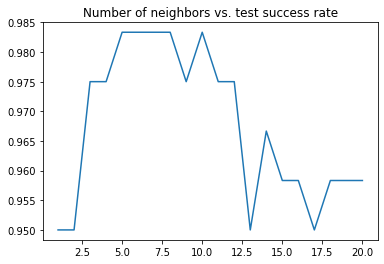

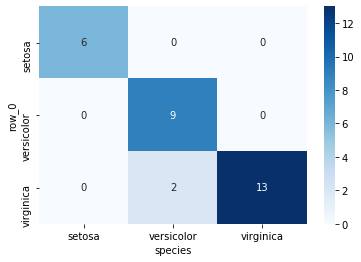

In [3]:
#seperate target from dataframe
y = iris_data['species']
x = iris_data.drop('species', axis=1)

#train/test split
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.20)

cv_with_kn = list()

for i in range(1,21):
    knn = KNeighborsClassifier(n_neighbors=i, p=2)

    knn.fit(x_train,y_train)

    cv_with_kn.append(sum(cross_val_score(knn, x_train, y_train, cv=5))/5)
 

#plotting k neighbor success rates on training data
#print(cv_with_kn)

#plt.figure(figsize=(10,6))
#plt.plot(range(1,21),cv_with_kn,color='blue', linestyle='dashed', marker='o',
#         markerfacecolor='red', markersize=10)
#plt.title('Success Rate vs. K Value')
#plt.xlabel('K')
#plt.ylabel('Success Percentage');

#from what I can tell, a k value of 6 seems to work best

test_success_rate = list()

for i in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=i, p=2)
    knn.fit(x_train,y_train)
    test_success_rate.append(sum(cross_val_score(knn, x_train, y_train, cv=5))/5)
    
plt.plot(range(1,21), test_success_rate)
plt.title("Number of neighbors vs. test success rate")
plt.show()

k_star = test_success_rate.index(max(test_success_rate)) + 1
final_model = KNeighborsClassifier(n_neighbors=k_star,p=2)
final_model.fit(x_train,y_train)
final_prediction = final_model.predict(x_test)

sns.heatmap(pd.crosstab(final_prediction, y_test), annot=True, cmap='Blues', fmt='g')
plt.show()

## Part 2 (120 points)

Build KNN from scratch, you must use an OOP approach.  You'll be doing the same exact thing as above essentially.  Make sure you can handle manhattan (p=1) or euclidian (p=2), and of course the number of neighbors.  You should be able to clearly document how to use your KNN classifier and I should be able to run it on euclidian and taxicab distance!

algorithm="brute" in the sklearn documentation is merely forcing the algorithm to run through a brute force performance, as opposed to using intelligent structures like heaps to speed up the execution.  We want to be able to compare timing to similar algorithms!  For this reason, do not worry about coding any tree-like structures up to save time.  This will consume coding time!  Although your algorithm will not be optimal, that is perfectly fine!  If you are interested in creating efficient machine learning algorithms from scratch you'll have those opportunities in life (and that will lead to a large salary)!

Couple quick assumptions:

your data contains d classes where d >= 2

your data contains n dimensions where n >= 1

**This is to say do not hardcore to merely be able to handle a single feature, and you also must be able to handle a n-ary output class (as opposed to merely Binary)**

**How to handle ties in this class:
Strategy for k with an even number of neighbors, decrease k by one until a majority decision is reached
his HAS to happen at k=1 or before (since k=1 cannot "tie"), you might consider a recursive approach!
Lots of creative opportunities to handle this in other cases (increase k, look at weights, randomly choose, etc) but we will
standardize our approach to decrementing k
If we were working with binary classified data (+,-), (stolen,not_stolen) etc we could merely just use k=odd to bypass this**

In [4]:
class knn_cs360:
    #ctor that takes in the number of neighbors and the distance metric
    def __init__(self, num_neighbors, distance_metric):
        self.n_neighbors = num_neighbors
        self.dist = distance_metric
    
    #fit method that simply stores the data
    def fit(self, x_data_inputted, y_data_inputted):
        self.x_data = x_data_inputted
        self.y_data = y_data_inputted
        
    def _euclid_dist(self, rowA, rowB):
        d = 0
        for i in range(0,len(rowA)):
            d += (rowA[i] - rowB[i])**2
        
        return d**(1/2)
    
    def _manhattain_dist(self, rowA, rowB):
        d = 0
        for i in range(0,len(rowA)):
            d += abs(rowA[i]-rowB[i])
        return d
    
    def _min_dist(self, d_list):
        min_d = d_list[0]
        for i in range(0,len(d_list)):
            if min_d[2] > d_list[i][2]:
                min_d = d_list[i]
        return min_d
    
    def _max_dist(self, d_list):
        max_d = d_list[0]
        for i in range(0,len(d_list)):
            if max_d[2] < d_list[i][2]:
                max_d = d_list[i]
        return max_d
    
    def _count_outcomes(self, n_list):
        #get all values of target column
        l = list()
        for n in n_list:
            l.append(n[1]["label"])
            
        #each unique target column value
        unique_l = list()
        for i in l:
            if i not in unique_l:
                unique_l.append(i)
            else:
                pass
            
        #count of each unique value in the target column
        count_list = list()
        for i in unique_l:
            count_list.append(l.count(i))
                
        #returns parallel lists
        #one has the value, the other the count (they share an index)
        return unique_l, count_list
    
    def _determine_winner(self, o_c_list):
        winner = max(o_c_list[1])
        
        #o_c_list[0] contains the count, [1] contains the value
        if o_c_list[1].count(winner) > 1:
            return "t"
        else:
            return o_c_list[0][o_c_list[1].index(winner)]
    
    #predict method
    def predict(self, test_data):
        
        #attach the correct label y to the data x
        self.x_data["label"] = self.y_data
        
        #calculate distance from test data to each row in x
        dist_list = list()

        #iterate over each row if the x data
        for index,row in self.x_data.iterrows():
            if(self.dist == "euclid"):
                dist_list.append([index, row, self._euclid_dist(test_data, row)])
            elif(self.dist == "manhattan"):
                dist_list.append([index, row, self._manhattain_dist(test_data, row)])
         
        neighbor_list = list()
        
        for n in range(0, self.n_neighbors):
            #get min value in dist list to get nearest neighbor, add to neighbor list
            nearest_n = self._min_dist(dist_list)
            neighbor_list.append(nearest_n)
            
            #drop from dist list in order to recalculate new min distance
            #finds index of min distance and drops
            pop_index = None
            for i in range(0, len(dist_list)):
                if dist_list[i][0] == nearest_n[0]:
                    pop_index = i
            dist_list.pop(pop_index)
            
        #get count of each outcome
        #break tie by decreasing k
        outcomes_and_count_lists = self._count_outcomes(neighbor_list)
        k_count = self.n_neighbors
        
        while(k_count > 0):
            if self._determine_winner(outcomes_and_count_lists) != "t":
                return self._determine_winner(outcomes_and_count_lists)
            else:
                #break tie by decreasing num of nieghbors by 1 (removing furthest neighbor)
                fartherst_n = self._max_dist(neighbor_list)
                pop_index = None
                for i in range(0,len(neighbor_list)):
                    if neighbor_list[i][0] == fartherst_n[0]:
                        pop_index = i
                neighbor_list.pop(i)
                k_count -= 1
                
                outcomes_and_count_lists = self._count_outcomes(neighbor_list)
        return "should never see this"

In [5]:
## For testing tiebreaker portion

import pandas as pd
tie_test = pd.read_csv("tiebreaker.csv")
tie_test.head()

,X1,X2,X3,Y
0,1,1,1,square
1,2,2,2,triangle
2,3,3,3,circle
3,4,4,4,triangle
4,5,5,5,circle


In [6]:
y_data = tie_test["Y"]
x_data=tie_test.drop("Y",axis=1)

## Use all 5 neighbors
myknn = knn_cs360(num_neighbors=5,distance_metric="euclid")
myknn.fit(x_data_inputted=x_data,y_data_inputted=y_data)
assert(myknn.predict([6,6,6])=="circle")
assert(myknn.predict([0,2,1])=="triangle")

## 4 Neighbors tricky case
myknn = knn_cs360(num_neighbors=4,distance_metric="manhattan")
myknn.fit(x_data_inputted=x_data,y_data_inputted=y_data)
assert(myknn.predict([4,3,4])=="circle")

## Start with 3 neighbors
myknn = knn_cs360(num_neighbors=3,distance_metric="euclid")
myknn.fit(x_data_inputted=x_data,y_data_inputted=y_data)
assert(myknn.predict([-1,-1,-1])=="square")
assert(myknn.predict([2,3,2])=="triangle")
assert(myknn.predict([6,6,6])=="circle")

## 2 neighbors this time
myknn = knn_cs360(num_neighbors=2,distance_metric="euclid")
myknn.fit(x_data_inputted=x_data,y_data_inputted=y_data)
assert(myknn.predict([1,2,1])=="square")
assert(myknn.predict([2,3,2])=="triangle")
assert(myknn.predict([3,4,3])=="circle")
assert(myknn.predict([4,5,4])=="triangle")
assert(myknn.predict([5,6,5])=="circle")

## 1 neighbor this time
myknn = knn_cs360(num_neighbors=1,distance_metric="euclid")
myknn.fit(x_data_inputted=x_data,y_data_inputted=y_data)
assert(myknn.predict([1,2,1])=="square")
assert(myknn.predict([2,3,2])=="triangle")
assert(myknn.predict([3,4,3])=="circle")
assert(myknn.predict([4,5,4])=="triangle")
assert(myknn.predict([5,6,5])=="circle")

print("If you made it here, it works.")

If you made it here, it works.
